### Read the joined NFL data in

In [0]:
nfl = spark.read.parquet("/FileStore/nfl_with_external/nfl_with_external.parquet")

In [0]:
tfidf_df = nfl.select('title','body')

#### Conduct basic data text checks / analysis on your data. What are the most common words overall or over time? What is the distribution of text lengths? What are important words according to TF-IDF?

#### Identify important keywords for your reddit data and use regex searches to create at least two dummy variables to identify comments of particular topics. -- 1. home/away, 2. 

#### Clean your text data using johnsnowlabs sparkNLP. Think about a few standard procedures to use: stop words, stemming, lemmatizing, removing unusual characters, matching synonyms, etc. You must use at least five NLP cleaning procedures.

### First, let's look at the length of the comments in our dataset
In this session, the comment length distribution is calculated. (split by space)

In [0]:
from pyspark.sql.functions import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style
tfidf_df=tfidf_df.withColumn("comment_length", size(split(col('body'), ' ')))

In [0]:
tfidf_df.show()

+--------------------+--------------------+--------------+
|               title|                body|comment_length|
+--------------------+--------------------+--------------+
|Post Game Thread:...|           Holy shit|             2|
|Post Game Thread:...|           Fuck yeah|             2|
|Post Game Thread:...|      Never in doubt|             3|
|Post Game Thread:...|     Wow. 😂😂😂😂😂|             2|
|Post Game Thread:...|The most prototyp...|             6|
|Post Game Thread:...| Yom Kippur everyone|             3|
|Post Game Thread:...|Guys. Am I alive ...|             6|
|Post Game Thread:...|I both hate and l...|             8|
|Post Game Thread:...|Well, we didn't d...|             9|
|Post Game Thread:...|Defense sucks Hei...|             4|
|Post Game Thread:...|           [deleted]|             1|
|Post Game Thread:...|    That was a game.|             4|
|Post Game Thread:...|I fucking hate th...|             5|
|Post Game Thread:...|This team is amaz...|             9|
|P

In [0]:
import os
PLOT_DIR = os.path.join("data", "plots")
CSV_DIR = os.path.join("data", "csv")
os.makedirs(PLOT_DIR, exist_ok=True)
os.makedirs(CSV_DIR, exist_ok=True)

In [0]:
PLOT_DIR

Out[2]: 'data/plots'

In [0]:
## histogram (by groupby)
hist_comment_length = tfidf_df.groupBy('comment_length').count().toPandas()
hist_comment_length = hist_comment_length.sort_values('comment_length')
hist_comment_length

,comment_length,count
31,1,651
137,2,229
38,3,297
73,4,295
50,5,315
...,...,...
163,441,1
134,499,1
188,527,1
102,591,1


In [0]:
hist_comment_length['cum_count'] = hist_comment_length['count'].cumsum()

#### Create a table contains cumulative comments count of every comment length

In [0]:
hist_comment_length

,comment_length,count,cum_count
31,1,651,651
137,2,229,880
38,3,297,1177
73,4,295,1472
50,5,315,1787
...,...,...,...
163,441,1,7507
134,499,1,7508
188,527,1,7509
102,591,1,7510


In [0]:
# save the results to csv
fpath = os.path.join(CSV_DIR, "hist_comment_length.csv")
hist_comment_length.to_csv(fpath)

In [0]:
## 90% cut
comment_length_90 = hist_comment_length.cum_count.iloc[-1]*0.9
x=hist_comment_length.cum_count<comment_length_90
ninty_cut = x.value_counts()
ninty_cut

Out[9]: False    143
True      46
Name: cum_count, dtype: int64

In [0]:
## 90%
hist_comment_length.iloc[ninty_cut.iloc[1]]


Out[10]: comment_length      47
count               24
cum_count         6769
Name: 29, dtype: int64

In [0]:
hist_comment_length_90 = hist_comment_length.iloc[:ninty_cut.iloc[1]]

In [0]:
hist_comment_length_90.head(10)

,comment_length,count,cum_count
31,1,651,651
137,2,229,880
38,3,297,1177
73,4,295,1472
50,5,315,1787
35,6,286,2073
81,7,269,2342
76,8,268,2610
67,9,260,2870
92,10,286,3156


<command-2117567251616192>:5: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.text(x[i],y[i]+20,y[i], ha = 'center',


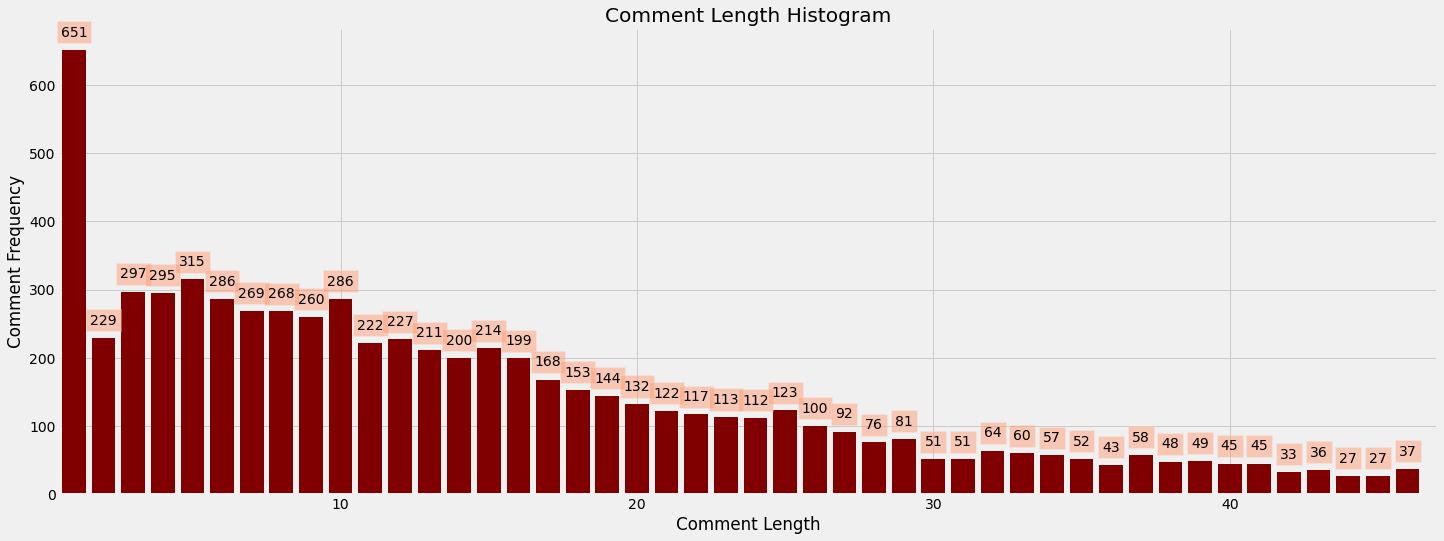

In [0]:
hist_comment_length_90 = hist_comment_length.iloc[:ninty_cut.iloc[1]]

def addlabels(x,y):
    for i in range(len(x)):
        plt.text(x[i],y[i]+20,y[i], ha = 'center',
                 Bbox = dict(facecolor = 'lightsalmon', alpha = .5))
        
fig = plt.figure(figsize = (22, 8))
plt.style.use('fivethirtyeight')
# creating the bar plot
plt.bar('comment_length', 'count', data=hist_comment_length_90, color='maroon') 
addlabels(hist_comment_length_90['comment_length'].tolist(), hist_comment_length_90['count'].tolist())
plt.title("Comment Length Histogram")
plt.xlabel("Comment Length")
plt.xlim([0.5, 47])
plt.ylabel("Comment Frequency")

## Save the plot in the plot dir so that it can be checked in into the repo
plot_fpath = os.path.join(PLOT_DIR, 'histogram_n_word_comment.png')
plt.savefig(plot_fpath)

plt.show()

### After calculating and counting the length of each comments, let's build a pipeline to clean our subreddit data to build a wordcloud

#### Build a pipieline for wordcloud

In [0]:
#%%time
document_assembler = DocumentAssembler()\
      .setInputCol("body")\
      .setOutputCol("document")
    
tokenizer = Tokenizer()\
      .setInputCols(["document"])\
      .setOutputCol("token")
      
normalizer = Normalizer()\
    .setInputCols(["token"])\
    .setOutputCol("normalized")\
    .setLowercase(True)\
    .setCleanupPatterns(["""[^\w\d\s]"""]) # remove punctuations (keep alphanumeric chars)
# if we don't set CleanupPatterns, it will only keep alphabet letters ([^A-Za-z])

stopwords_cleaner = StopWordsCleaner()\
      .setInputCols("normalized")\
      .setOutputCol("cleanTokens")\
      .setCaseSensitive(False)

finisher = Finisher() \
    .setInputCols(["cleanTokens"]) \
    .setOutputCols(["token_features"]) \
    .setOutputAsArray(True) \
    .setCleanAnnotations(False)# To generate Term Frequency

# convert labels (string) to integers. Easy to process compared to string.
label_stringIdx = StringIndexer(inputCol = "title", outputCol = "label")

nlp_pipeline = Pipeline(stages=[document_assembler, 
            tokenizer,    
            normalizer,
            stopwords_cleaner,
            finisher,
#             hashingTF,
#             idf,
            label_stringIdx])
#             lr,
#             label_to_stringIdx])



#### For the sake of better understanding each word in wordcloud, this wordcloud pipeline did not use stemmer function to lemmatize the words

In [0]:
nlp_model_wordcloud = nlp_pipeline.fit(tfidf_df)

processed_wordcloud = nlp_model_wordcloud.transform(tfidf_df)

In [0]:
words = processed_wordcloud.select('token_features').cache()

In [0]:
words.show(3)

+--------------+
|token_features|
+--------------+
|  [holy, shit]|
|  [fuck, yeah]|
|[never, doubt]|
+--------------+
only showing top 3 rows



In [0]:
from pyspark.sql.functions import concat_ws

words = words.withColumn("words", concat_ws(" ", "token_features")).cache()

In [0]:
words_df=words.select('words').toPandas()['words']
words_list=list(words_df)
words_text = ' '.join(words_list)
words_text

#### Let's make a wordcloud of all the comments across the total 17 games

In [0]:
!pip install WordCloud

     |████████████████████████████████| 458 kB 10.8 MB/s 
You should consider upgrading via the '/local_disk0/.ephemeral_nfs/envs/pythonEnv-ba68d2f0-8453-496f-980c-2460c177959a/bin/python -m pip install --upgrade pip' command.


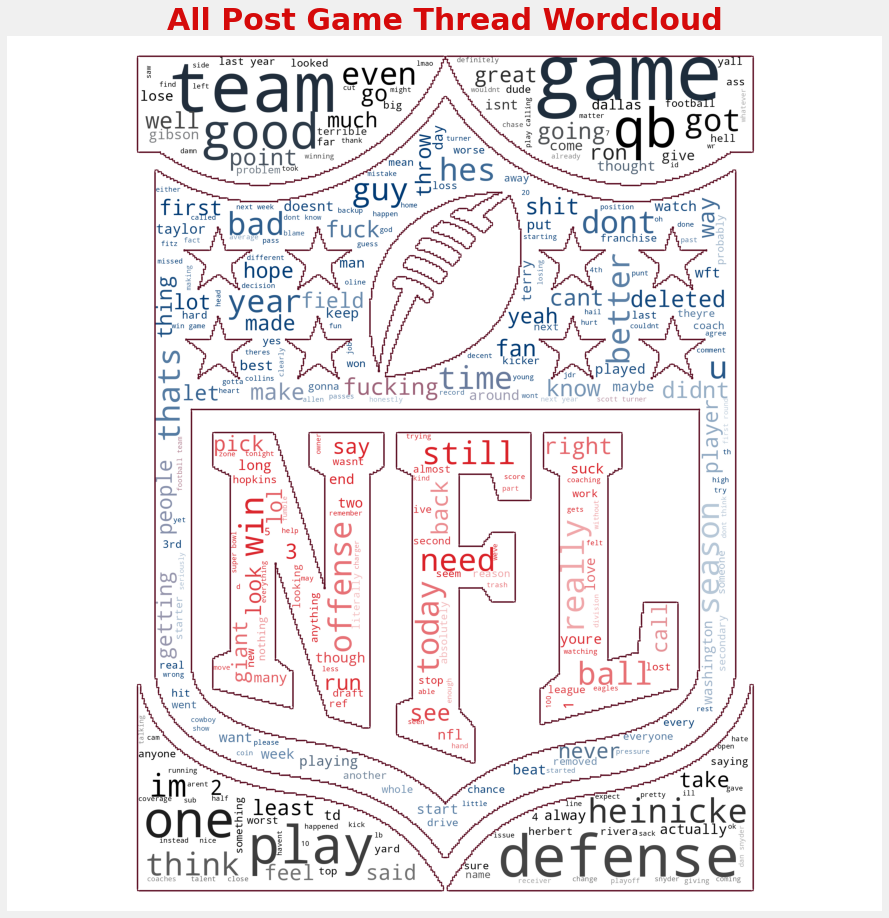

In [0]:
from wordcloud import WordCloud
from wordcloud import ImageColorGenerator
from wordcloud import STOPWORDS
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from PIL import Image
 
#Create the mask
colosseum_mask = np.array(Image.open('image/nfl-league-logo.png'))
#Grab the mask colors
colors = ImageColorGenerator(colosseum_mask)
#Filter out stop words
stopwords = set(STOPWORDS)
wordcloud = WordCloud(mask=colosseum_mask,
                      scale=6,
                      include_numbers=True,
                      max_words=10000000,
                      color_func=colors,
                      background_color='white',
                      stopwords=stopwords,
                      collocations=True,
                      contour_color='#5d0f24', #013369
                      contour_width=3,
                      relative_scaling=0.5,
                      min_font_size=4, #colormap='Reds_r'
                      max_font_size=60).generate_from_text(words_text)
plt.figure(figsize=(15,15))
plt.imshow(wordcloud)
plt.axis("off")
plt.title('All Post Game Thread Wordcloud', x=0.5, y=1, fontweight="bold", color="#d50a0a", size=30)

# Save the plot in the plot dir so that it can be checked in into the repo
plot_fpath = os.path.join(PLOT_DIR, 'all_post_game_thread_wordcloud.png')
plt.savefig(plot_fpath)
plt.show()

#### Let's visualize the total comments number in each post game thread

In [0]:
from pyspark.sql.functions import desc
processed_wordcloud.groupBy("title").count().sort(desc('count')).show(5,truncate=False)

+------------------------------------------------------------------+-----+
|title                                                             |count|
+------------------------------------------------------------------+-----+
|Post Game Thread: New York Giants at Washington Football Team     |1025 |
|Post Game Thread: Los Angeles Chargers at Washington Football Team|699  |
|Post Game Thread: Dallas Cowboys at Washington Football Team      |584  |
|Post Game Thread: New Orleans Saints at Washington Football Team  |565  |
|Post Game Thread: Seattle Seahawks at Washington Football Team    |555  |
+------------------------------------------------------------------+-----+
only showing top 5 rows



In [0]:
comment_count = processed_wordcloud.groupBy("title").count().sort(desc('count')).cache().toPandas()

In [0]:
# save the results to csv
fpath = os.path.join(CSV_DIR, "all_post_game_thread_comments_count.csv")
comment_count.to_csv(fpath)

<command-1798786091073615>:6: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.text(y[i]+30, x[i],y[i], ha = 'center',


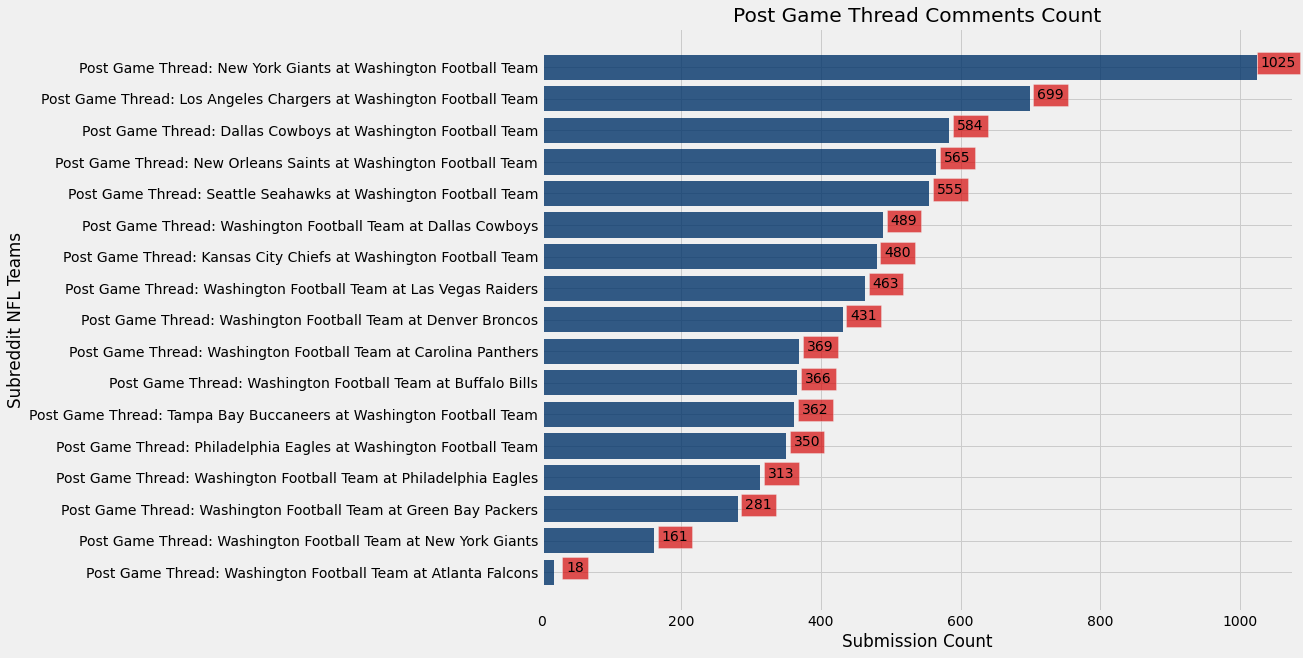

In [0]:
import matplotlib.pyplot as plt
from matplotlib import style
        
def addlabels(x,y):
    for i in range(len(x)):
        plt.text(y[i]+30, x[i],y[i], ha = 'center',
                 Bbox = dict(facecolor = '#d50a0a', alpha = .7))
# Using the style for the plot
fig, ax = plt.subplots()
plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = [12, 10]
plt.barh('title','count', data=comment_count, color='#013369',alpha=0.8)
addlabels(comment_count['title'], comment_count['count'])
plt.ylabel("Subreddit NFL Teams")
plt.xlabel("Submission Count")
plt.title('Post Game Thread Comments Count')

# Save the plot in the plot dir so that it can be checked in into the repo
plot_fpath = os.path.join(PLOT_DIR, 'post_game_thread_comments_count.png')
plt.savefig(plot_fpath)
ax.invert_yaxis()
plt.show()


#### Since New York Giants and Washington Commanders' game had the highest amount of comments, let's make the wordcloud for that game

In [0]:
Giant_Commenders = processed_wordcloud.filter(col('title')=='Post Game Thread: New York Giants at Washington Football Team').cache()

In [0]:
Giant_Commenders.show(5)

+--------------------+--------------------+--------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-----+
|               title|                body|comment_length|            document|               token|          normalized|         cleanTokens|      token_features|         rawFeatures|            features|label|
+--------------------+--------------------+--------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-----+
|Post Game Thread:...|           Holy shit|             2|[{document, 0, 8,...|[{token, 0, 3, Ho...|[{token, 0, 3, ho...|[{token, 0, 3, ho...|        [holy, shit]|(1000,[460,753],[...|(1000,[460,753],[...|  0.0|
|Post Game Thread:...|           Fuck yeah|             2|[{document, 0, 8,...|[{token, 0, 3, Fu...|[{token, 0, 3, fu...|[{token, 0, 3, fu...|        [f

In [0]:
words_Giant_Commenders = Giant_Commenders.select('token_features').cache()

In [0]:
words_Giant_Commenders.show(5)

+--------------------+
|      token_features|
+--------------------+
|        [holy, shit]|
|        [fuck, yeah]|
|      [never, doubt]|
|               [wow]|
|[prototypical, wa...|
+--------------------+
only showing top 5 rows



In [0]:
from pyspark.sql.functions import concat_ws

words_Giant_Commenders = words_Giant_Commenders.withColumn("words", concat_ws(" ", "token_features")).cache()

In [0]:
words_df_GC=words_Giant_Commenders.select('words').toPandas()['words']
words_list_GC=list(words_df_GC)
words_text_GC = ' '.join(words_list_GC)
words_text_GC

In [0]:
!pip install WordCloud

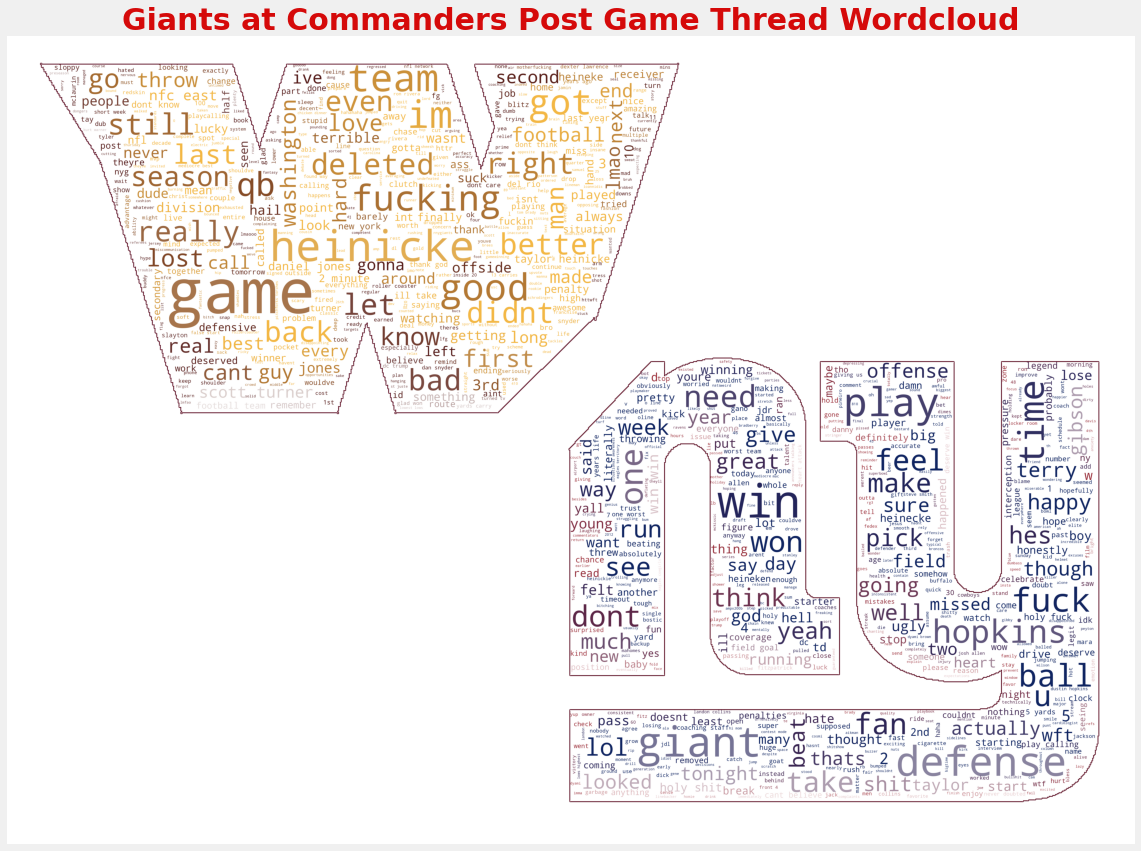

In [0]:
from wordcloud import WordCloud
from wordcloud import ImageColorGenerator
from wordcloud import STOPWORDS
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from PIL import Image
 
#Create the mask
colosseum_mask = np.array(Image.open('image/GC.png'))
#Grab the mask colors
colors = ImageColorGenerator(colosseum_mask)
#Filter out stop words
stopwords = set(STOPWORDS)
wordcloud = WordCloud(mask=colosseum_mask,
                      scale=6,
                      include_numbers=True,
                      max_words=10000000,
                      color_func=colors,
                      background_color='white',
                      stopwords=stopwords,
                      collocations=True,
                      contour_color='#5d0f24', #013369
                      contour_width=5,
                      relative_scaling=0.5,
                      min_font_size=4, #colormap='Reds_r'
                      max_font_size=70).generate_from_text(words_text_GC)
plt.figure(figsize=(18,15))
plt.imshow(wordcloud)
plt.axis("off")
plt.title('Giants at Commanders Post Game Thread Wordcloud', x=0.5, y=1, fontweight="bold", color="#d50a0a", size=30)

# Save the plot in the plot dir so that it can be checked in into the repo
plot_fpath = os.path.join(PLOT_DIR, 'giants_at_commanders_post_game_thread_wordcloud.png')
plt.savefig(plot_fpath)
plt.show()

### Now let's use our pipeline again with stemmer function to calculate TF-IDF of each word

In [0]:
# spark = SparkSession\
#         .builder\
#         .appName("TfIdf_Example")\
#         .getOrCreate()

In [0]:
import sparknlp
from sparknlp.base import *
from sparknlp.annotator import *
from pyspark.ml import Pipeline
from pyspark.ml.feature import HashingTF, IDF, StringIndexer, CountVectorizer

In [0]:

stemmer = Stemmer()\
      .setInputCols(["cleanTokens"])\
      .setOutputCol("stem")

finisher = Finisher() \
    .setInputCols(["stem"]) \
    .setOutputCols(["token_features"]) \
    .setOutputAsArray(True) \
    .setCleanAnnotations(False)

# # To generate Term Frequency
# hashingTF = HashingTF(inputCol="token_features", outputCol="TF", numFeatures=1000)

# # To generate Inverse Document Frequency
# idf = IDF(inputCol="TF", outputCol="IDF", minDocFreq=5)

# convert labels (string) to integers. Easy to process compared to string.
label_stringIdx = StringIndexer(inputCol = "title", outputCol = "label")


# countVectors = CountVectorizer(inputCol="token_features", outputCol="features", vocabSize=10000, minDF=5)

# label_stringIdx = StringIndexer(inputCol = "features", outputCol = "label")

nlp_pipeline = Pipeline(stages=[document_assembler, 
            tokenizer,    
            normalizer,
            stopwords_cleaner,
            stemmer, 
            finisher,
#             hashingTF,
#             idf,
            label_stringIdx])
#             lr,
#             label_to_stringIdx])

nlp_model = nlp_pipeline.fit(tfidf_df)

processed = nlp_model.transform(tfidf_df)

processed.count()

Out[171]: 7511

In [0]:
processed.show()

+--------------------+--------------------+--------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-----+
|               title|                body|comment_length|            document|               token|          normalized|         cleanTokens|                stem|      token_features|label|
+--------------------+--------------------+--------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-----+
|Post Game Thread:...|           Holy shit|             2|[{document, 0, 8,...|[{token, 0, 3, Ho...|[{token, 0, 3, ho...|[{token, 0, 3, ho...|[{token, 0, 3, ho...|        [holi, shit]|  0.0|
|Post Game Thread:...|           Fuck yeah|             2|[{document, 0, 8,...|[{token, 0, 3, Fu...|[{token, 0, 3, fu...|[{token, 0, 3, fu...|[{token, 0, 3, fu...|        [fuck, yeah]|  0.0|
|Post Game Thread:...|      Never in doubt|  

In [0]:
clean_terms = processed.select('title','token_features')
clean_terms.show()

+--------------------+--------------------+
|               title|      token_features|
+--------------------+--------------------+
|Post Game Thread:...|        [holi, shit]|
|Post Game Thread:...|        [fuck, yeah]|
|Post Game Thread:...|      [never, doubt]|
|Post Game Thread:...|               [wow]|
|Post Game Thread:...|[prototyp, washin...|
|Post Game Thread:...|[yom, kippur, eve...|
|Post Game Thread:...|   [gui, aliv, dead]|
|Post Game Thread:...|[hate, love, hopk...|
|Post Game Thread:...|[well, didnt, des...|
|Post Game Thread:...|[defens, suck, he...|
|Post Game Thread:...|             [delet]|
|Post Game Thread:...|              [game]|
|Post Game Thread:...|  [fuck, hate, game]|
|Post Game Thread:...|[team, amaz, dont...|
|Post Game Thread:...|                  []|
|Post Game Thread:...|       [offsid, wow]|
|Post Game Thread:...|             [remov]|
|Post Game Thread:...|      [cant, believ]|
|Post Game Thread:...|             [delet]|
|Post Game Thread:...|[hopkin, b

In [0]:
clean_terms_rdd = clean_terms.rdd

In [0]:
clean_terms_rdd.take(5)

Out[176]: [Row(title='Post Game Thread: New York Giants at Washington Football Team', token_features=['holi', 'shit']),
 Row(title='Post Game Thread: New York Giants at Washington Football Team', token_features=['fuck', 'yeah']),
 Row(title='Post Game Thread: New York Giants at Washington Football Team', token_features=['never', 'doubt']),
 Row(title='Post Game Thread: New York Giants at Washington Football Team', token_features=['wow']),
 Row(title='Post Game Thread: New York Giants at Washington Football Team', token_features=['prototyp', 'washington', 'game', 'ever'])]

#### Here we calculate TF-IDF for each word and document

In [0]:
import math
from pyspark.sql.functions import *

map1=clean_terms_rdd.flatMap(lambda x: [((x[0],i),1) for i in x[1]])
reduce=map1.reduceByKey(lambda x,y:x+y)
tf=reduce.map(lambda x: (x[0][1],(x[0][0],x[1])))
map3=reduce.map(lambda x: (x[0][1],(x[0][0],x[1],1)))
map4=map3.map(lambda x:(x[0],x[1][2]))
reduce2=map4.reduceByKey(lambda x,y:x+y)
idf=reduce2.map(lambda x: (x[0],math.log10(7511/x[1])))
rdd=tf.join(idf)
rdd=rdd.map(lambda x: (x[1][0][0],(x[0],x[1][0][1],x[1][1],x[1][0][1]*x[1][1]))).sortByKey()
rdd=rdd.map(lambda x: (x[0],x[1][0],x[1][1],x[1][2],x[1][3]))
rdd.toDF(["title","Token","TF","IDF","TF-IDF"]).show()

+--------------------+------+---+------------------+------------------+
|               title| Token| TF|               IDF|            TF-IDF|
+--------------------+------+---+------------------+------------------+
|Post Game Thread:...|  yeah| 17| 2.671577779324283| 45.41682224851281|
|Post Game Thread:...| giant|  3|2.6996065029245266|  8.09881950877358|
|Post Game Thread:...| divis|  2| 2.671577779324283| 5.343155558648566|
|Post Game Thread:...|taylor|  8|  2.72956972630197| 21.83655781041576|
|Post Game Thread:...|  info|  1|3.3985765072605454|3.3985765072605454|
|Post Game Thread:...|  jone|  8| 2.875697761980208|23.005582095841664|
|Post Game Thread:...|  ball| 34| 2.671577779324283| 90.83364449702562|
|Post Game Thread:...| still| 32| 2.645248840601934| 84.64796289926188|
|Post Game Thread:...|   god|  5|  2.72956972630197|13.647848631509849|
|Post Game Thread:...| hadnt|  2|3.1767277576441892|6.3534555152883785|
|Post Game Thread:...| danni|  1| 2.834305076821983| 2.834305076

In [0]:
tfidf_rdd_df = rdd.toDF(["title","Token","TF","IDF","TF-IDF"])

In [0]:
tfidf_rdd_df.show()

+--------------------+------+---+------------------+------------------+
|               title| Token| TF|               IDF|            TF-IDF|
+--------------------+------+---+------------------+------------------+
|Post Game Thread:...|  yeah| 17| 2.671577779324283| 45.41682224851281|
|Post Game Thread:...| giant|  3|2.6996065029245266|  8.09881950877358|
|Post Game Thread:...| divis|  2| 2.671577779324283| 5.343155558648566|
|Post Game Thread:...|taylor|  8|  2.72956972630197| 21.83655781041576|
|Post Game Thread:...|  info|  1|3.3985765072605454|3.3985765072605454|
|Post Game Thread:...|  jone|  8| 2.875697761980208|23.005582095841664|
|Post Game Thread:...|  ball| 34| 2.671577779324283| 90.83364449702562|
|Post Game Thread:...| still| 32| 2.645248840601934| 84.64796289926188|
|Post Game Thread:...|   god|  5|  2.72956972630197|13.647848631509849|
|Post Game Thread:...| hadnt|  2|3.1767277576441892|6.3534555152883785|
|Post Game Thread:...| danni|  1| 2.834305076821983| 2.834305076

In [0]:
from pyspark.sql.window import Window
from pyspark.sql.functions import col, row_number
windowDept = Window.partitionBy("title").orderBy(col("TF-IDF").desc())
ranked_tfidf=tfidf_rdd_df.withColumn("rank",row_number().over(windowDept))
ranked_tfidf.filter(col('rank').isin([1,2,3,4,5])).show(truncate=False)

+------------------------------------------------------------------+------+---+-----------------+------------------+----+
|title                                                             |Token |TF |IDF              |TF-IDF            |rank|
+------------------------------------------------------------------+------+---+-----------------+------------------+----+
|Post Game Thread: Dallas Cowboys at Washington Football Team      |game  |146|2.645248840601934|386.20633072788235|1   |
|Post Game Thread: Dallas Cowboys at Washington Football Team      |get   |73 |2.645248840601934|193.10316536394117|2   |
|Post Game Thread: Dallas Cowboys at Washington Football Team      |remov |66 |2.72956972630197 |180.15160193593002|3   |
|Post Game Thread: Dallas Cowboys at Washington Football Team      |team  |68 |2.645248840601934|179.87692116093152|4   |
|Post Game Thread: Dallas Cowboys at Washington Football Team      |like  |63 |2.645248840601934|166.65067695792183|5   |
|Post Game Thread: Kansa

In [0]:
# save the results to csv
top5_tfidfpd = ranked_tfidf.filter(col('rank').isin([1,2,3,4,5])).toPandas()
fpath = os.path.join(CSV_DIR, "top5_tfidfpd.csv")
top5_tfidfpd.to_csv(fpath)

#### Add NY Giants at Washington Commanders label back to filtered TF-IDF dataframe

In [0]:
giants_at_commanders_tfidf = ranked_tfidf.filter(col('title')=='Post Game Thread: New York Giants at Washington Football Team')

In [0]:
giants_at_commanders_tfidf.show(5)

+--------------------+-------+---+-----------------+------------------+----+
|               title|  Token| TF|              IDF|            TF-IDF|rank|
+--------------------+-------+---+-----------------+------------------+----+
|Post Game Thread:...|   game|194|2.645248840601934| 513.1782750767752|   1|
|Post Game Thread:...|    win|141|2.645248840601934|372.98008652487266|   2|
|Post Game Thread:...|   fuck|113|2.645248840601934|298.91311898801854|   3|
|Post Game Thread:...|heinick| 90|2.645248840601934|238.07239565417404|   4|
|Post Game Thread:...| defens| 85|2.645248840601934| 224.8461514511644|   5|
+--------------------+-------+---+-----------------+------------------+----+
only showing top 5 rows

